In [6]:
import pandas as pd
import numpy as np
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import re
from scipy.stats import ttest_1samp

Cleaned columns: ['icln_icln', 'xle_xle', 'vix_vix', 'brent_bz_f', 'sp500_gspc', 'dgs10', 'carbon_eua', 'icln_icln_ret', 'xle_xle_ret', 'brent_bz_f_ret', 'carbon_eua_ret', 'sp500_gspc_ret', 'dgs10_diff', 'carbon_shock_resid', 'carbon_shock', 'icln_vol', 'xle_vol']

Detected columns:
icln_ret_col: icln_icln_ret
xle_ret_col: xle_xle_ret
icln_vol_col: icln_vol
xle_vol_col: xle_vol
carbon_shock_col: carbon_shock_resid
vix_col: vix_vix
brent_col: brent_bz_f
sp500_ret_col: None
dgs10_col: dgs10
dgs10_diff_col: dgs10_diff

Macro controls in feature matrix: ['vix_vix', 'brent_bz_f', 'dgs10']

Fitting Causal Forest for ICLN returns (N=1754 rows)...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.0s finis


ICLN Average Treatment Effect (ATE): 0.05893378779516597


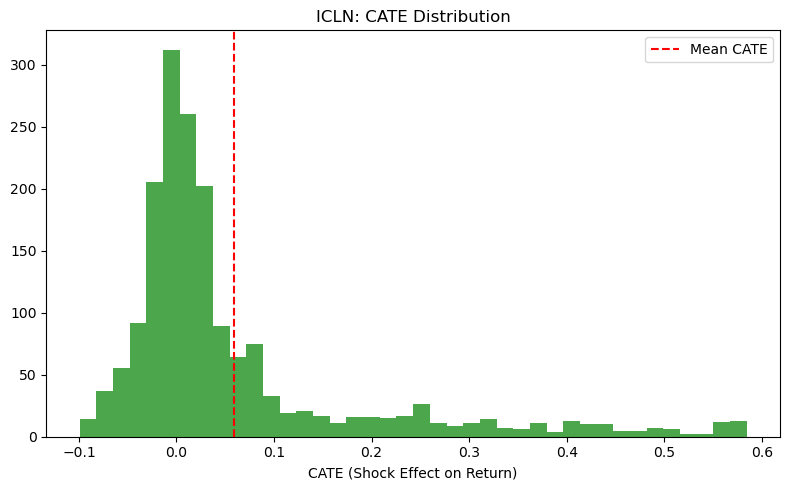


Fitting Causal Forest for XLE returns (N=1754 rows)...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.0s finis


XLE Average Treatment Effect (ATE): 0.1331271526151847


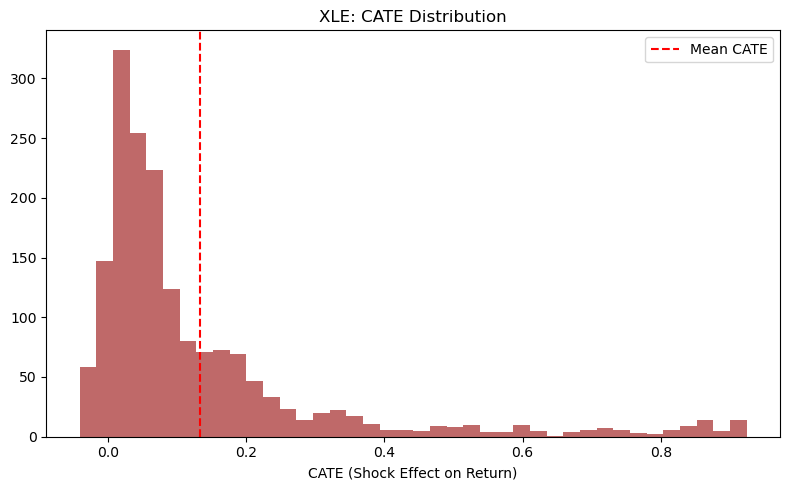


Done.


In [4]:
df = pd.read_csv('/Users/marcomontenegro/Desktop/MSQE PROJECT/Project_Data/financial_data_returns_shocks_vol_2018_2024.csv', index_col=0, parse_dates=True)

def clean_col(col):
    s = re.sub(r'[^0-9a-zA-Z_]+', '_', col).strip('_')
    s = re.sub(r'_+', '_', s)
    return s.lower()

df.columns = [clean_col(col) for col in df.columns]
print("Cleaned columns:", list(df.columns))

def find_col(substring, columns):
    substring = substring.lower().strip('_')
    for col in columns:
        if substring in col.strip('_').lower():
            return col
    return None

# Key columns for both ETFs
icln_ret_col = find_col('icln_ret', df.columns)
xle_ret_col  = find_col('xle_ret', df.columns)
icln_vol_col = find_col('icln_vol', df.columns)
xle_vol_col  = find_col('xle_vol', df.columns)
carbon_shock_col = find_col('carbon_shock', df.columns)
vix_col = find_col('vix', df.columns)
brent_col = find_col('brent', df.columns)
sp500_ret_col = find_col('sp500_ret', df.columns)
dgs10_col = find_col('dgs10', df.columns)
dgs10_diff_col = find_col('dgs10_diff', df.columns)

# Print detected
print("\nDetected columns:")
for varname, val in [
    ("icln_ret_col", icln_ret_col), ("xle_ret_col", xle_ret_col),
    ("icln_vol_col", icln_vol_col), ("xle_vol_col", xle_vol_col),
    ("carbon_shock_col", carbon_shock_col),
    ("vix_col", vix_col), ("brent_col", brent_col),
    ("sp500_ret_col", sp500_ret_col), ("dgs10_col", dgs10_col), ("dgs10_diff_col", dgs10_diff_col)
]:
    print(f"{varname}: {val}")

# Helper: Build list of valid macro controls for feature matrix
def valid_controls(cols, df):
    controls = []
    for col in cols:
        if col and col in df.columns:
            ser = df[col]
            if pd.api.types.is_numeric_dtype(ser) and ser.notnull().sum() > 1 and ser.nunique(dropna=True) > 1:
                controls.append(col)
    return controls

macro_controls = valid_controls([vix_col, brent_col, sp500_ret_col, dgs10_col], df)
print("\nMacro controls in feature matrix:", macro_controls)

# For both ETFs: run causal forest only if all required columns are present
results = []
for label, ret_col, vol_col in [
    ('ICLN', icln_ret_col, icln_vol_col),
    ('XLE', xle_ret_col, xle_vol_col)
]:
    if ret_col and vol_col and carbon_shock_col:
        df_sub = df.dropna(subset=[ret_col, vol_col, carbon_shock_col] + macro_controls)
        Y = df_sub[ret_col].values
        T = df_sub[carbon_shock_col].values
        X = df_sub[[vol_col] + macro_controls].values
        print(f"\nFitting Causal Forest for {label} returns (N={len(df_sub)} rows)...")
        est = CausalForestDML(
            model_y=RandomForestRegressor(n_estimators=100, min_samples_leaf=10),
            model_t=RandomForestRegressor(n_estimators=100, min_samples_leaf=10),
            n_estimators=500,
            min_samples_leaf=10,
            verbose=1,
            random_state=42
        )
        est.fit(Y, T, X=X)
        ate = est.ate(X)
        cate = est.effect(X)
        print(f"\n{label} Average Treatment Effect (ATE): {ate}")
        # Save/plot CATEs
        plt.figure(figsize=(8,5))
        plt.hist(cate, bins=40, alpha=0.7, color=('green' if label == 'ICLN' else 'brown'))
        plt.axvline(np.mean(cate), color='red', linestyle='--', label='Mean CATE')
        plt.title(f'{label}: CATE Distribution')
        plt.xlabel('CATE (Shock Effect on Return)')
        plt.legend()
        plt.tight_layout()
        plt.show()
        results.append((label, ate, np.mean(cate), np.std(cate)))
    else:
        print(f"Skipping {label}: Missing required columns.")

print("\nDone.")



ICLN mean CATE: 0.05970
ICLN: t-stat = 19.15, p = 0.0000
ICLN bootstrapped 95% CI: 0.05394 to 0.06548
ICLN Placebo mean CATE: -0.00220, std = 0.04764


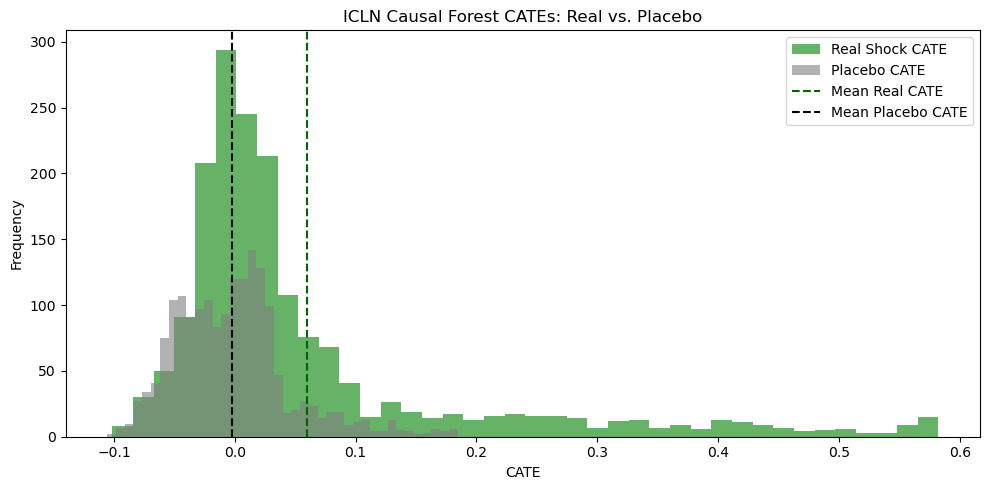


XLE mean CATE: 0.13301
XLE: t-stat = 29.40, p = 0.0000
XLE bootstrapped 95% CI: 0.12410 to 0.14191
XLE Placebo mean CATE: 0.01920, std = 0.04632


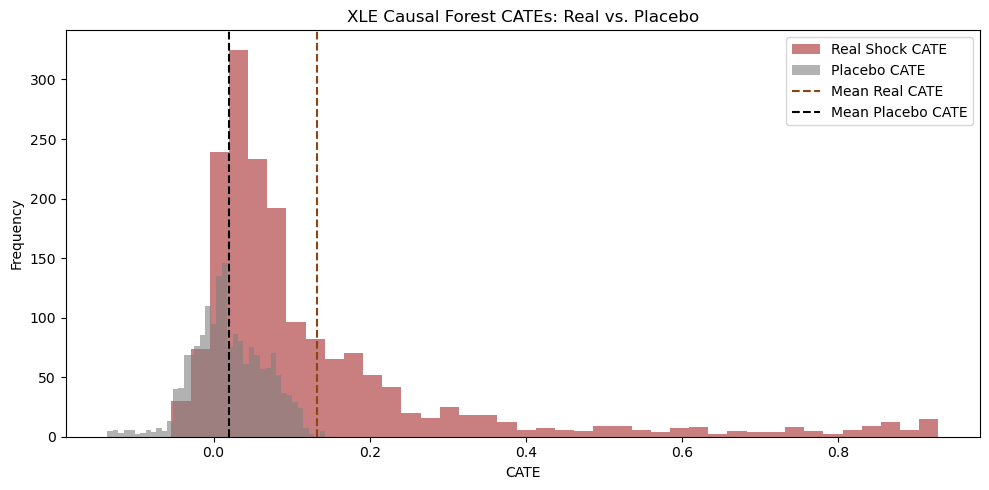

In [8]:
df = pd.read_csv('/Users/marcomontenegro/Desktop/MSQE PROJECT/Project_Data/financial_data_returns_shocks_vol_2018_2024.csv', index_col=0, parse_dates=True)
def clean_col(col):
    s = re.sub(r'[^0-9a-zA-Z_]+', '_', col).strip('_')
    s = re.sub(r'_+', '_', s)
    return s.lower()
df.columns = [clean_col(col) for col in df.columns]

def find_col(substring, columns):
    substring = substring.lower().strip('_')
    for col in columns:
        if substring in col.strip('_').lower():
            return col
    return None

# Helper for valid macro controls
def valid_controls(cols, df):
    controls = []
    for col in cols:
        if col and col in df.columns:
            ser = df[col]
            if pd.api.types.is_numeric_dtype(ser) and ser.notnull().sum() > 1 and ser.nunique(dropna=True) > 1:
                controls.append(col)
    return controls

vix_col = find_col('vix', df.columns)
brent_col = find_col('brent', df.columns)
sp500_ret_col = find_col('sp500_ret', df.columns)
dgs10_col = find_col('dgs10', df.columns)
dgs10_diff_col = find_col('dgs10_diff', df.columns)
macro_controls = valid_controls([vix_col, brent_col, sp500_ret_col, dgs10_col], df)

icln_ret_col = find_col('icln_ret', df.columns)
icln_vol_col = find_col('icln_vol', df.columns)
xle_ret_col = find_col('xle_ret', df.columns)
xle_vol_col = find_col('xle_vol', df.columns)
carbon_shock_col = find_col('carbon_shock', df.columns)

def bootstrap_ci(series, n_boot=1000, ci=95):
    means = []
    for _ in range(n_boot):
        means.append(series.sample(frac=1, replace=True).mean())
    lower = np.percentile(means, (100-ci)/2)
    upper = np.percentile(means, 100-(100-ci)/2)
    return lower, upper

results_df = []

for label, ret_col, vol_col in [
    ('ICLN', icln_ret_col, icln_vol_col),
    ('XLE', xle_ret_col, xle_vol_col)
]:
    try:
        cate_path = f'/Users/marcomontenegro/Desktop/MSQE PROJECT/Project_Data/{label.lower()}_causal_forest_cates.csv'
        cate = pd.read_csv(cate_path, parse_dates=['date'], index_col='date')
        cate_col = cate.columns[0]
        print(f"\n{label} mean CATE: {cate[cate_col].mean():.5f}")

        t_stat, p_val = ttest_1samp(cate[cate_col], 0)
        print(f"{label}: t-stat = {t_stat:.2f}, p = {p_val:.4f}")

        ci = bootstrap_ci(cate[cate_col])
        print(f"{label} bootstrapped 95% CI: {ci[0]:.5f} to {ci[1]:.5f}")

        # Placebo test (shuffle shocks)
        df_sub = df.dropna(subset=[ret_col, vol_col, carbon_shock_col] + macro_controls)
        Y = df_sub[ret_col].values
        T_real = df_sub[carbon_shock_col].values
        X = df_sub[[vol_col] + macro_controls].values
        np.random.seed(42)
        T_fake = np.random.permutation(T_real)
        est_fake = CausalForestDML(
            model_y=RandomForestRegressor(n_estimators=100, min_samples_leaf=10),
            model_t=RandomForestRegressor(n_estimators=100, min_samples_leaf=10),
            n_estimators=500,
            min_samples_leaf=10,
            verbose=0,
            random_state=42
        )
        est_fake.fit(Y, T_fake, X=X)
        fake_cate = est_fake.effect(X)
        print(f"{label} Placebo mean CATE: {np.mean(fake_cate):.5f}, std = {np.std(fake_cate):.5f}")

        # Histogram: Real vs. Placebo CATEs
        plt.figure(figsize=(10,5))
        plt.hist(cate[cate_col], bins=40, alpha=0.6, label='Real Shock CATE', color='green' if label == 'ICLN' else 'brown')
        plt.hist(fake_cate, bins=40, alpha=0.6, label='Placebo CATE', color='gray')
        plt.axvline(np.mean(cate[cate_col]), color='darkgreen' if label == 'ICLN' else 'saddlebrown', linestyle='--', label='Mean Real CATE')
        plt.axvline(np.mean(fake_cate), color='black', linestyle='--', label='Mean Placebo CATE')
        plt.title(f'{label} Causal Forest CATEs: Real vs. Placebo')
        plt.xlabel('CATE')
        plt.ylabel('Frequency')
        plt.legend()
        plt.tight_layout()
        plt.show()

        results_df.append({
            'ETF': label,
            'Mean_CATE': cate[cate_col].mean(),
            'T_stat': t_stat,
            'P_value': p_val,
            'Bootstrapped_CI_low': ci[0],
            'Bootstrapped_CI_high': ci[1],
            'Placebo_Mean_CATE': np.mean(fake_cate),
            'Placebo_Std_CATE': np.std(fake_cate)
        })
    except Exception as e:
        print(f"Could not compute robustness for {label}: {e}")

